In [1]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
import itertools

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler


In [4]:
train = pd.read_csv('/home/lab10/Dacon/contest/public_data/train.csv')
# 시간 데이터 인덱스
train['date'] = pd.to_datetime(train['date'])
train = train.set_index(train['date'])
train = train.iloc[:, 1:]
train.head(5)

,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,15019.0,...,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-04,월요일,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,141638.0,...,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
2016-01-05,화요일,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,1112.6,4342.0,126207.8,...,32615.0,6926.0,147638.0,2268.0,231958.0,2178.0,8810.0,2853.0,0.0,0.0


In [5]:
mon=train.loc[train['요일']=='월요일']
mon=mon.drop(['요일'], axis=1)
tue=train.loc[train['요일']=='화요일']
tue=tue.drop(['요일'], axis=1)
wed=train.loc[train['요일']=='수요일']
wed=wed.drop(['요일'], axis=1)
tur=train.loc[train['요일']=='목요일']
tur=tur.drop(['요일'], axis=1)
fri=train.loc[train['요일']=='금요일']
fri=fri.drop(['요일'], axis=1)
sat=train.loc[train['요일']=='토요일']
sat=sat.drop(['요일'], axis=1)
sun=train.loc[train['요일']=='일요일']
sun=sun.drop(['요일'], axis=1)



In [6]:
mon

,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,141638.0,5210.0,...,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
2016-01-11,1161028.0,398.0,1940798.7,336.0,1651529.5,1215.0,73.0,5712.0,65579.5,4956.0,...,33310.8,3116.0,284347.0,2183.0,337420.0,2431.0,2039.8,2133.0,0.0,0.0
2016-01-18,1125796.0,475.0,1575175.4,344.0,1333422.3,1176.0,162.6,5161.0,71881.7,5066.0,...,28880.0,3718.0,299638.6,2236.0,292668.0,3215.0,1918.8,4871.0,0.0,0.0
2016-01-25,676054.0,641.0,1368930.2,644.0,1014462.0,1234.0,295.0,6814.0,86403.6,5835.0,...,21334.6,3705.0,250259.6,2798.0,248915.0,3669.0,934.8,3415.0,0.0,0.0
2016-02-01,1803744.5,638.0,2679932.8,760.0,2389867.0,1327.0,991.7,4922.0,109419.7,5756.0,...,32305.6,5187.0,266575.5,3882.0,316559.0,4229.0,1409.8,3429.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,1441152.8,1133.0,1461107.5,888.0,1760687.9,931.0,6560.6,25085.0,145167.4,3483.0,...,50353.6,2730.0,559140.4,1820.0,598686.4,1127.0,676035.4,3872.0,88006.2,12433.0
2020-09-07,975020.2,1614.0,1425166.5,1013.0,1665721.0,966.0,1949.6,24526.0,40900.3,5037.0,...,31758.8,7013.0,261191.1,3414.0,253155.0,3414.0,447623.4,4009.0,80482.7,12762.0
2020-09-14,1221538.6,2042.0,1675569.2,925.0,2526891.5,961.0,6578.0,24068.0,102969.1,5145.0,...,58284.9,6203.0,443129.3,2917.0,366871.2,3178.0,630664.5,3587.0,174048.8,11452.0


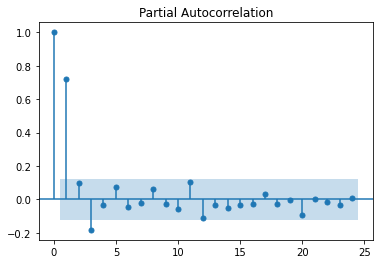

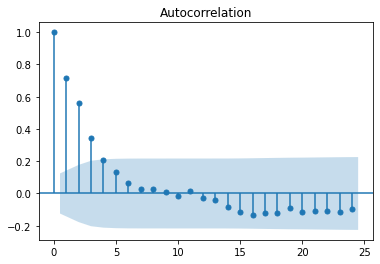

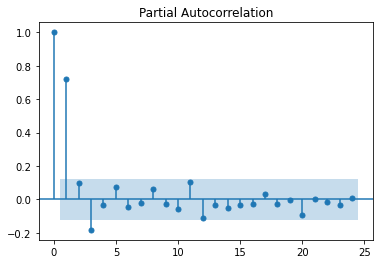

In [7]:
plot_acf(mon['배추_거래량(kg)'])
plot_pacf(mon['배추_거래량(kg)'])

In [8]:
mm_mon=MinMaxScaler().fit_transform(mon)
mm_mon=pd.DataFrame(mm_mon)
mm_mon.columns = ['배추_거래량(kg)', '배추_가격(원/kg)', '무_거래량(kg)', '무_가격(원/kg)',
       '양파_거래량(kg)', '양파_가격(원/kg)', '건고추_거래량(kg)', '건고추_가격(원/kg)',
       '마늘_거래량(kg)', '마늘_가격(원/kg)', '대파_거래량(kg)', '대파_가격(원/kg)',
       '얼갈이배추_거래량(kg)', '얼갈이배추_가격(원/kg)', '양배추_거래량(kg)', '양배추_가격(원/kg)',
       '깻잎_거래량(kg)', '깻잎_가격(원/kg)', '시금치_거래량(kg)', '시금치_가격(원/kg)',
       '미나리_거래량(kg)', '미나리_가격(원/kg)', '당근_거래량(kg)', '당근_가격(원/kg)',
       '파프리카_거래량(kg)', '파프리카_가격(원/kg)', '새송이_거래량(kg)', '새송이_가격(원/kg)',
       '팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)', '토마토_거래량(kg)', '토마토_가격(원/kg)',
       '청상추_거래량(kg)', '청상추_가격(원/kg)', '백다다기_거래량(kg)', '백다다기_가격(원/kg)',
       '애호박_거래량(kg)', '애호박_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']
mm_mon

,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,0.273068,0.234084,0.440354,0.315442,0.460735,0.794212,0.023292,0.056587,0.129684,0.812159,...,0.457792,0.508361,0.227365,0.435690,0.745976,0.462102,0.001814,0.15540,0.000000,0.000000
1,0.222837,0.194907,0.502831,0.277457,0.328679,0.781350,0.002432,0.072407,0.060045,0.772564,...,0.395827,0.207581,0.129120,0.464864,0.405627,0.556675,0.001369,0.08532,0.000000,0.000000
2,0.216075,0.232615,0.408103,0.284063,0.265371,0.756270,0.005418,0.065423,0.065815,0.789712,...,0.343176,0.247685,0.136064,0.476150,0.351828,0.736203,0.001287,0.19484,0.000000,0.000000
3,0.129755,0.313908,0.354668,0.531792,0.201893,0.793569,0.009830,0.086377,0.079111,0.909587,...,0.253516,0.246819,0.113641,0.595826,0.299231,0.840165,0.000627,0.13660,0.000000,0.000000
4,0.346194,0.312439,0.694329,0.627581,0.475619,0.853376,0.033045,0.062393,0.100185,0.897272,...,0.383882,0.345547,0.121050,0.826661,0.380549,0.968399,0.000946,0.13716,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,0.276601,0.554848,0.378550,0.733278,0.350403,0.598714,0.218610,0.317986,0.132915,0.542946,...,0.598344,0.181867,0.253902,0.387564,0.719706,0.258072,0.453612,0.15488,0.230224,0.340630
244,0.187136,0.790402,0.369238,0.836499,0.331503,0.621222,0.064964,0.310900,0.037448,0.785191,...,0.377385,0.467191,0.118605,0.727002,0.304328,0.781772,0.300350,0.16036,0.210543,0.349644
245,0.234451,1.000000,0.434114,0.763832,0.502889,0.618006,0.219190,0.305095,0.094279,0.802027,...,0.692590,0.413230,0.201222,0.621167,0.441031,0.727731,0.423169,0.14348,0.455311,0.313753
246,0.392745,0.887855,0.606421,0.720066,0.496406,0.634727,0.256953,0.174503,0.103958,0.796726,...,0.797511,0.326427,0.202084,0.619037,0.552068,0.770781,0.394282,0.14260,0.707234,0.310603


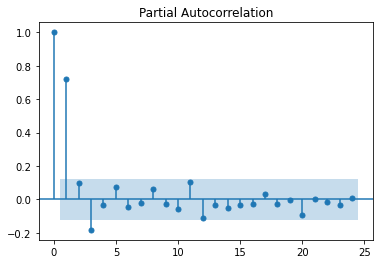

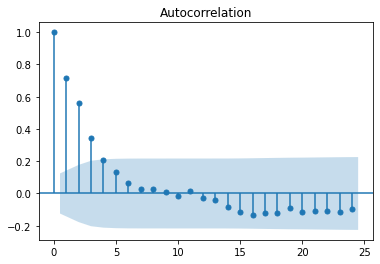

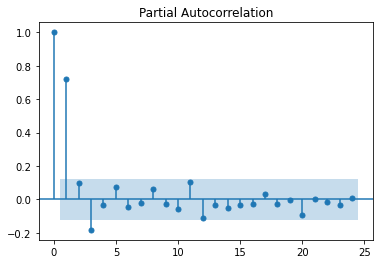

In [9]:
plot_acf(mm_mon['배추_거래량(kg)'])
plot_pacf(mm_mon['배추_거래량(kg)'])

In [10]:
model=ARIMA(mm_mon['배추_거래량(kg)'],order=(0,1,1))
model_fit=model.fit()
model_fit.summary()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.배추_거래량(kg)   No. Observations:                  247
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 181.499
Method:                       css-mle   S.D. of innovations              0.116
Date:                Thu, 23 Sep 2021   AIC                           -356.999
Time:                        16:38:55   BIC                           -346.471
Sample:                             1   HQIC                          -352.760
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0007      0.006      0.124      0.902      -0.011       0.012
ma.L1.D.배추_거래량(kg)    -0.2080      0.063     -3.316      0.001      -0.331      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            4.8075           +0.0000j            4.8075            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
print('Ex')
p=range(0,3)
d=range(1,2)
q=range(0,3)
pdq=list(itertools.product(p, d, q))

aic=[]
for i in pdq:
    model = ARIMA(mm_mon['배추_거래량(kg)'], order=(i))
    model_fit=model.fit()
    print(f'Arima: {i} >> AIC : {round(model_fit.aic,2)}')
        aic.append(round(model_fit.aic,2))
    

Ex
Arima: (0, 1, 0) >> AIC : -347.71
Arima: (0, 1, 1) >> AIC : -357.0
Arima: (0, 1, 2) >> AIC : -355.68
Arima: (1, 1, 0) >> AIC : -358.3
Arima: (1, 1, 1) >> AIC : -357.69


/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.